<a href="https://colab.research.google.com/github/zhouyunsong/PracticalAI/blob/master/Multilayer_Perceptrons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load PyTorch library
!pip3 install torch torchvision

In [0]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

In [0]:
# Arguments
args = Namespace(
    seed=1234,
    num_samples_per_class=500,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=100,
    learning_rate=1e-0,
    regularization=1e-3,
    num_epochs=200,
)

# Set seed for reproducability
np.random.seed(args.seed)

In [0]:
# Generate non-linear data
def generate_data(num_samples_per_class, dimensions, num_classes):
    # Make synthetic spiral data
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    for j in range(num_classes):
        ix = range(num_samples_per_class*j,num_samples_per_class*(j+1))
        r = np.linspace(0.0,1,num_samples_per_class) # radius
        t = np.linspace(j*4,(j+1)*4,num_samples_per_class) + \
        np.random.randn(num_samples_per_class)*0.2 # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    # Stack
    X = np.hstack([X_original])

    return X, y

In [23]:
# Generate X & y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class, 
                     dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

X: (1500, 2)
y: (1500,)


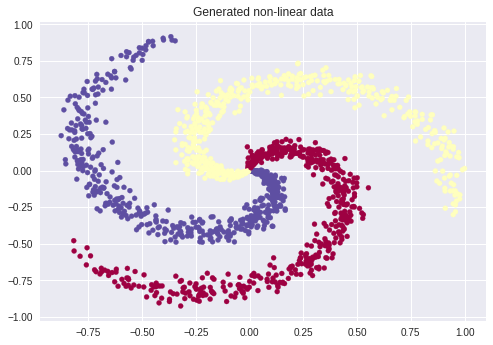

In [27]:
# Visualize data
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap=plt.cm.Spectral)
plt.show()

In [0]:
# Convert to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

In [26]:
# Shuffle data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 1125 train samples and 375 test samples.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [0]:
# Linear model
class LogisticClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LogisticClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = self.fc1(x_in)
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [30]:
# Initialize model
model = LogisticClassifier(input_dim=args.dimensions, 
                           hidden_dim=args.num_hidden_units, 
                           output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [0]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) # Adam optimizer (usually better than SGD)

In [0]:
# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [33]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.0483 | acc: 56.3%
epoch: 20 | loss: 9.0695 | acc: 53.8%
epoch: 40 | loss: 1.6579 | acc: 56.2%
epoch: 60 | loss: 1.9344 | acc: 61.5%
epoch: 80 | loss: 0.7654 | acc: 56.0%
epoch: 100 | loss: 0.7261 | acc: 54.9%
epoch: 120 | loss: 0.7180 | acc: 55.2%
epoch: 140 | loss: 0.7178 | acc: 55.1%
epoch: 160 | loss: 0.7177 | acc: 55.0%
epoch: 180 | loss: 0.7177 | acc: 55.1%


In [0]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [35]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 55.1%, test acc: 49.6%


In [0]:
# Visualization
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

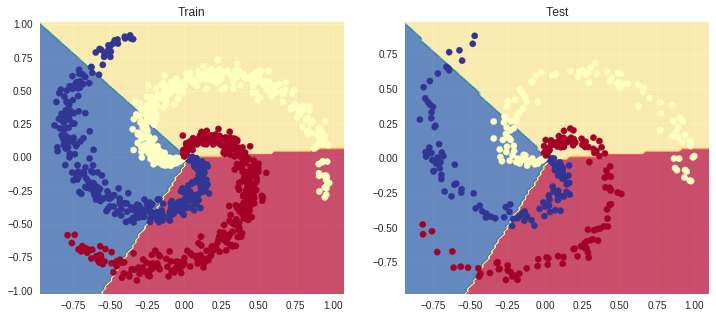

In [37]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

In [0]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

              precision    recall  f1-score   support

           0       0.47      0.50      0.49       124
           1       0.51      0.52      0.51       124
           2       0.50      0.47      0.49       127

   micro avg       0.50      0.50      0.50       375
   macro avg       0.50      0.50      0.50       375
weighted avg       0.50      0.50      0.50       375



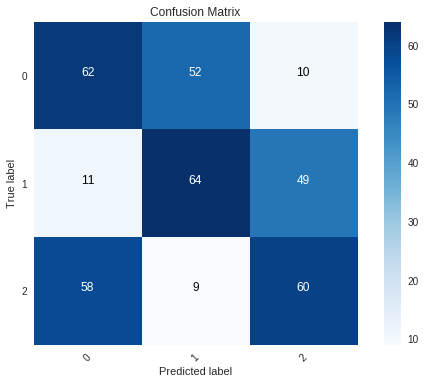

In [40]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

In [0]:
# Multilayer Perceptron 
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [42]:
# Initialize model
model = MLP(input_dim=args.dimensions, 
            hidden_dim=args.num_hidden_units, 
            output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [0]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [44]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.1191 | acc: 26.3%
epoch: 20 | loss: 0.5295 | acc: 67.3%
epoch: 40 | loss: 0.2584 | acc: 87.3%
epoch: 60 | loss: 0.1387 | acc: 94.0%
epoch: 80 | loss: 0.0614 | acc: 98.3%
epoch: 100 | loss: 0.0344 | acc: 99.6%
epoch: 120 | loss: 0.0253 | acc: 99.8%
epoch: 140 | loss: 0.0210 | acc: 99.9%
epoch: 160 | loss: 0.0183 | acc: 99.9%
epoch: 180 | loss: 0.0165 | acc: 99.8%


In [0]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [46]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 99.8%, test acc: 98.7%


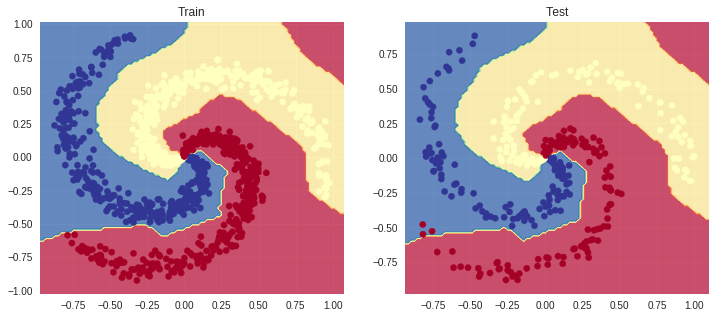

In [47]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       124
           1       1.00      1.00      1.00       124
           2       0.98      0.98      0.98       127

   micro avg       0.99      0.99      0.99       375
   macro avg       0.99      0.99      0.99       375
weighted avg       0.99      0.99      0.99       375



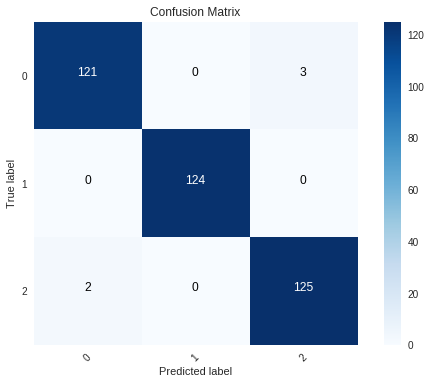

In [48]:

# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

In [0]:
# Install TensorboardX
!pip3 install tensorboardX

In [0]:
# Run tensorboard on port 6006
LOG_DIR = './log'
run_num = 0
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [51]:
# Install localtunnel
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.1
added 54 packages from 32 contributors in 2.392s


In [0]:
# Tunnel port 6006 for tensorboard
get_ipython().system_raw('lt --port 6006 >> tensorboard.txt 2>&1 &')

In [65]:
# Few things needed to get tensorboard working
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
# Initialize the Tensorboard writer
run_num += 1
writer = SummaryWriter(log_dir=LOG_DIR+"/run_{}".format(run_num))

In [56]:
# Initialize model
model = MLP(input_dim=args.dimensions, 
            hidden_dim=args.num_hidden_units, 
            output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [0]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [0]:
def write_weights(writer, model, epoch_num):
    for name, param in model.named_parameters():
        
        # Weights
        writer.add_scalar(name+"/mean", param.data.numpy().mean(), epoch_num)
        writer.add_scalar(name+"/std", param.data.numpy().std(), epoch_num)
        
        # Gradients
        writer.add_scalar(name+"/grad_mean", torch.mean(param.grad), epoch_num)
        writer.add_scalar(name+"/grad_std", torch.std(param.grad), epoch_num)
        
        # Weights histogram (dim over 1024 cause an error)
        if len(param.size()) > 1 and param.size()[-1] <= 1024: 
            writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch_num)

In [59]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    
    # Write to tensorboard
    writer.add_scalar('metrics/train_loss', loss, t)
    writer.add_scalar('metrics/train_acc', accuracy, t)
    writer.add_scalar('metrics/lr', optimizer.param_groups[0]['lr'], t)
    write_weights(writer=writer, model=model, epoch_num=t)

epoch: 00 | loss: 1.0881 | accuracy: 33.4%
epoch: 20 | loss: 0.3090 | accuracy: 88.9%
epoch: 40 | loss: 0.1102 | accuracy: 93.6%
epoch: 60 | loss: 0.0416 | accuracy: 98.5%
epoch: 80 | loss: 0.0259 | accuracy: 99.6%
epoch: 100 | loss: 0.0205 | accuracy: 99.7%
epoch: 120 | loss: 0.0177 | accuracy: 99.7%
epoch: 140 | loss: 0.0158 | accuracy: 99.7%
epoch: 160 | loss: 0.0144 | accuracy: 99.8%
epoch: 180 | loss: 0.0133 | accuracy: 99.8%


In [67]:
print ("Go to this link below to see the Tensorboard:")
!cat tensorboard.txt
print ("Click on SCALARS to see metrics and DISTRIBUTIONS to see weights.")

Go to this link below to see the Tensorboard:
your url is: https://short-stingray-96.localtunnel.me
/tools/node/lib/node_modules/localtunnel/bin/client:65
        throw err;
        ^

Error: connection refused: localtunnel.me:35852 (check your firewall settings)
    at Socket.<anonymous> (/tools/node/lib/node_modules/localtunnel/lib/TunnelCluster.js:47:32)
    at emitOne (events.js:116:13)
    at Socket.emit (events.js:211:7)
    at emitErrorNT (internal/streams/destroy.js:64:8)
    at _combinedTickCallback (internal/process/next_tick.js:138:11)
    at process._tickCallback (internal/process/next_tick.js:180:9)
your url is: https://slimy-mayfly-62.localtunnel.me
Click on SCALARS to see metrics and DISTRIBUTIONS to see weights.
